In [68]:
import sys, os, re
import numpy as np
import pandas as pd

# set root directory
sys.path.append("../")
from utils.utils import get_featuredata, list_features
import utils.utils as utils

# utils.apply_defaults(set_cwd=True)

# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D/spher_colo52_v1
/share/data/analyses/christa/colopaint3D/spher_colo52_v1


In [69]:
# Setup
BaseDir = './results-medmean/'

figformat = 'pdf'
dpi = 300

In [70]:
# Select cell line and compound to analyze

cell_line = 'HCT116'
data_type = 'aggregates'
# data_type = '2D'
cmpd="Fluor"
conc = 10.0

title = f"{cell_line} exposed to {cmpd} for {data_type} profiles"

In [71]:
# Load the data
dir = '1_Data/results/'
data =  pd.read_parquet(('{}grit_data_{}_{}.parquet').format(dir, data_type, cell_line))

# Only keep relevant columns
metadata = ['Metadata_pert_name', 
            'Metadata_cell_line', 
            'Metadata_name',
            'Metadata_cmpd_conc',
            ]

# Calculate aggregated data
aggregate_df = get_featuredata(data.set_index(metadata)).groupby(metadata).median().reset_index()


# Work with a single cell line and drug at first
compound_df = aggregate_df.query('Metadata_cell_line == @cell_line & Metadata_name == @cmpd & Metadata_cmpd_conc == @conc')

In [72]:
compound_df

,Metadata_pert_name,Metadata_cell_line,Metadata_name,Metadata_cmpd_conc,RadialDistribution_ZernikePhase_SYTO_7_5_cytoplasm,RadialDistribution_ZernikePhase_PHAandWGA_3_1_cytoplasm,AreaShape_Zernike_2_0_nuclei,RadialDistribution_ZernikePhase_PHAandWGA_4_2_cytoplasm,Granularity_1_HOECHST_nuclei,Granularity_4_PHAandWGA_nuclei,...,AreaShape_Compactness_cytoplasm,AreaShape_Zernike_6_2_cytoplasm,RadialDistribution_ZernikeMagnitude_MITO_4_0_nuclei,RadialDistribution_MeanFrac_PHAandWGA_1of4_nuclei,RadialDistribution_ZernikePhase_HOECHST_7_7_cells,RadialDistribution_ZernikePhase_MITO_3_1_nuclei,Granularity_4_SYTO_cells,RadialDistribution_ZernikePhase_HOECHST_5_1_cytoplasm,RadialDistribution_ZernikePhase_HOECHST_9_1_cytoplasm,RadialDistribution_ZernikePhase_MITO_5_1_cytoplasm
65,Fluor_10.0,HCT116,Fluor,10.0,-0.024046,-0.123025,0.000784,0.020527,-0.279309,0.081812,...,0.105528,-0.074158,0.3166,0.744593,-0.347636,0.18405,0.359659,-0.011786,0.185549,-0.263158


In [73]:
# ## Load and process data

# # Import data
# selected_df = pd.read_csv("{}/selected_data_medmean.csv".format(BaseDir),
#                           index_col=0,
#                           low_memory=False)

# selected_df['Metadata_pert_name'] = (selected_df['Metadata_name'] + '_' + 
#                                        selected_df['Metadata_cmpd_conc'].astype(str) + '_' + 
#                                        selected_df['Metadata_cell_line'])

# # Only keep relevant columns
# metadata = ['Metadata_pert_name', 
#             'Metadata_cell_line', 
#             'Metadata_name',
#             'Metadata_cmpd_conc',
#             ]

# # Calculate aggregated data
# aggregate_df = get_featuredata(selected_df.set_index(metadata)).groupby(metadata).median().reset_index()


# # Work with a single cell line and drug at first
# compound_df = aggregate_df.query('Metadata_cell_line == @cell_line & Metadata_name == @cmpd & Metadata_cmpd_conc == @conc')


In [74]:
def remove_illum(s: str) -> str:
    return s.replace('illum', '')

def feature_grouping(df, perturbation="Metadata_pert_name"):
    df = utils.get_featuredata(compound_df.set_index(perturbation))
    df.columns = [remove_illum(col) for col in df.columns]

    # Transpose and rename
    df = df.T.reset_index().rename(columns={'index': 'feature_name'})

    # # Do the grouping
    df['feature_type'] =df['feature_name'].str.split("_").str[0]
    df['compartment'] = df['feature_name'].str.split('_').str[-1]
    df['channel'] = df['feature_name'].str.split('_').str[2]


    ## Fix up the grouping
    mask_keep = (
    ~df["feature_type"].str.contains("Children|Parent")
    & ~df["feature_name"].str.contains("Location_Center")
    & ~df["channel"].str.contains("Image", na=False)
    )
    df = df.loc[mask_keep].copy()

    # The compartment for AreaOccupied is off
    df.loc[
    (df['feature_type'] == 'AreaOccupied'),
    'compartment'
    ] = df['feature_name'].str.split('_').str[2]

    df.loc[
    df['feature_type'].isin(['AreaOccupied', "Number", "ObjectNumber"]),
    'feature_type'
    ] = "Count"

    # AreaShape and Neighbours do not have a channel 
    df.loc[
        df['feature_type'].isin(['AreaShape', "Neighbors", "Count"]),
        'channel'
    ] = np.nan

    # Location features are actually intensity features    
    df.loc[
    (df['feature_type'] == 'Location'),
    'channel'
    ] = df['feature_name'].str.split('_').str[3]

    df.loc[
        (df['feature_type'] == 'Location'),
        'feature_type'
    ] = "Intensity"

    return df

In [75]:
# Perform the feature grouping

df = feature_grouping(compound_df, perturbation="Metadata_pert_name")

# Count how many features per group
display(df.groupby(['feature_type'])['feature_name'].count())

df.drop(columns='feature_name', inplace=True)

feature_type
AreaShape             107
Correlation            58
Count                   1
Granularity           100
Intensity              17
Neighbors               7
RadialDistribution    307
Name: feature_name, dtype: int64

In [76]:
def compute_fractions(group):
    # Select only numeric columns in this group‐DataFrame
    num = group.select_dtypes(include='number')
    
    # For each numeric column, compute two fractions
    results = {}
    for col in num.columns:
        # results[f"{col}_fraction_above_2"]   = (num[col]  >  2).mean()
        # results[f"{col}_fraction_below_neg2"] = (num[col]  < -2).mean()
        results[f"fraction_pos"]   = (num[col]  >  2).mean()
        results[f"fraction_neg"] = (num[col]  < -2).mean()
    
    return pd.Series(results)


def compute_means(group):
    # Select only numeric columns in this group‐DataFrame
    num = group.select_dtypes(include='number')
    
    # For each numeric column, compute two fractions
    results = {}
    for col in num.columns:
        results[f"fraction_pos"] = num.loc[num[col] > 0, col].median()
        results[f"fraction_neg"] = num.loc[num[col] < 0, col].median()
    
    return pd.Series(results)


# Some features do not have a channel, so we need to handle those separately
# This is the case for AreaShape, Neighbours, and Count features
has_channel = df[df['channel'].notna()]
no_channel = df[df['channel'].isna()]

mean_df = (
    has_channel
    .groupby(['compartment', 'feature_type', 'channel'])
    .apply(compute_means, include_groups=False)
)


mean_df_nochannel = (
    no_channel
    .groupby(['compartment', 'feature_type'])
    .apply(compute_means, include_groups=False)
)


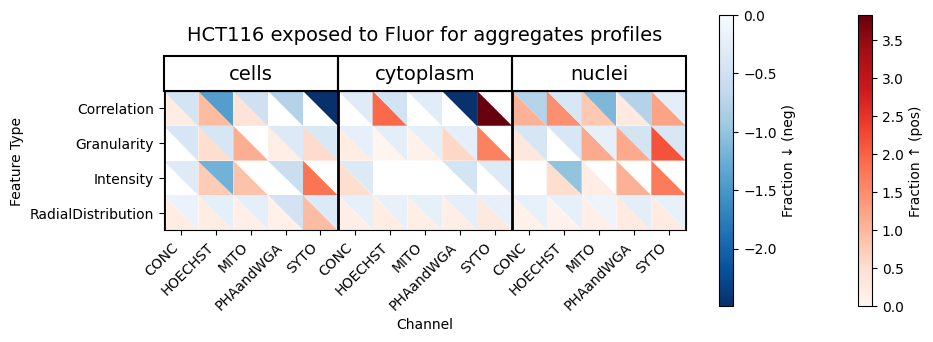

In [77]:
def plot_feature_heatmap(stat_df, title):
    ## Inspired by this post. https://stackoverflow.com/questions/63530701/python-package-to-plot-two-heatmaps-in-one-split-each-square-into-two-triangles
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Polygon, Rectangle


    """
    Instead of taking the absolute value of the statistics, we want to visulalize features that either increase or decrease
    in response to a perturbation. This is done by calculating a summary statistic (mean) of positive and negative features for each channel and feature type.
    Plot a heatmap with square tiles split into two triangles:
      - Top-left triangle: positive features (colored with Reds)
      - Bottom-right triangle: negative features (colored with Blues)
    """

    # Extract unique labels
    index_levels = ['compartment', 'feature_type', 'channel']
    compartments, feature_types, channels = [
        stat_df.index.get_level_values(level).unique().tolist()
        for level in index_levels
]

    # Build a list of (compartment, channel) pairs in column order
    col_levels = []
    for comp in compartments:
        for ch in channels:
            # Check if any feature_type exists under (comp, ch)
            if any((comp, ftype, ch) in stat_df.index for ftype in feature_types):
                col_levels.append((comp, ch))

    # Sorted list of feature_types for rows
    row_levels = sorted(feature_types)

    # Initialize 2D arrays
    n_rows = len(row_levels)     # number of feature types
    n_cols = len(col_levels)     # number of (compartment, channel) pairs
    pos_array = np.full((n_rows, n_cols), np.nan)
    neg_array = np.full((n_rows, n_cols), np.nan)

    # Fill pos_array/neg_array
    for i, (comp, ch) in enumerate(col_levels):
        for j, ftype in enumerate(row_levels):
            idx = (comp, ftype, ch)
            if idx in stat_df.index:
                pos_array[j, i] = stat_df.loc[idx, 'fraction_pos']
                neg_array[j, i] = stat_df.loc[idx, 'fraction_neg']

    # Colormap choices
    norm_pos = plt.Normalize(vmin=0, vmax=np.nanmax(pos_array))
    norm_neg = plt.Normalize(vmin=np.nanmin(neg_array), vmax=0)
    
    cmap_pos = plt.cm.Reds
    cmap_neg = plt.cm.Blues_r
    

    # Create figure & axis
    fig, ax = plt.subplots(
        figsize=(max(10, n_cols * 0.5), max(10, n_rows * 0.5))
    )
    ax.set_aspect('equal')

    # Draw each square cell as two triangles
    for j in range(n_rows):
        for i in range(n_cols):
            x0, y0 = i, j
            # Top-left triangle (positive fraction)
            tri_top = [(x0,   y0+1), (x0,   y0),   (x0+1, y0+1)]
            # Bottom-right triangle (negative fraction)
            tri_bot = [(x0,   y0),   (x0+1, y0),   (x0+1, y0+1)]

            val_pos = pos_array[j, i]
            if not np.isnan(val_pos):
                # color_pos = cmap_pos(val_pos) 
                color_pos = cmap_pos(norm_pos(val_pos)) 
                patch_top = Polygon(tri_top, facecolor=color_pos, edgecolor='none')
                ax.add_patch(patch_top)

            val_neg = neg_array[j, i]
            if not np.isnan(val_neg):
                # color_neg = cmap_neg(val_neg)
                color_neg = cmap_neg(norm_neg(val_neg))
                patch_bot = Polygon(tri_bot, facecolor=color_neg, edgecolor='none')
                ax.add_patch(patch_bot)

    # Set ticks and labels
    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_xticklabels(
        [ch for (_, ch) in col_levels],
        rotation=45, ha='right'
    )
    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_yticklabels(row_levels)

    # Draw compartment boundaries and labels (top margin)
    current_x = 0
    for comp in compartments:
        count = sum(1 for (c, _) in col_levels if c == comp)
        if count == 0:
            continue

        ax.axvline(current_x, color='black', lw=2)
        mid = (current_x + (current_x + count)) / 2

        # Text label just above the rectangle (at y = -0.3)
        ax.text(
            mid, -0.2, comp,
            ha='center', va='bottom', size=14
        )

        # Rectangle from y = -1 to y = 0
        rect = Rectangle(
            (current_x, -1),  # lower-left corner
            count,           # width
            1,               # height
            fill=False,
            edgecolor='black',
            linewidth=1.5,
            clip_on=False
        )
        ax.add_patch(rect)

        current_x += count

    # Close final boundary
    ax.axvline(n_cols, color='black', lw=2)

    # Final axis adjustments
    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows)
    ax.invert_yaxis()
    ax.set_xlabel("Channel")
    ax.set_ylabel("Feature Type")
    plt.tight_layout()

    # Add two colorbars
    sm_pos = plt.cm.ScalarMappable(cmap=cmap_pos, norm=plt.Normalize(vmin=0, vmax=np.nanmax(pos_array)))
    sm_pos.set_array([0, np.nanmax(pos_array)])
    cbar_pos = fig.colorbar(sm_pos, ax=ax, shrink=0.3)
    cbar_pos.set_label('Fraction ↑ (pos)')

    sm_neg = plt.cm.ScalarMappable(cmap=cmap_neg, norm=plt.Normalize(vmin=np.nanmin(neg_array), vmax=0))
    sm_neg.set_array([np.nanmin(neg_array), 0])
    cbar_neg = fig.colorbar(sm_neg, ax=ax, shrink=0.3)
    cbar_neg.set_label('Fraction ↓ (neg)')

    plt.title(title, y=1.3, size=14)
    plt.show()


# Plot the fractions in a heatmap
plot_feature_heatmap(mean_df, title)

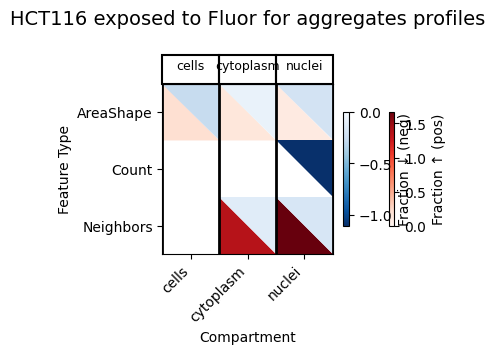

In [78]:
## Now plot a separate heatmap for neighbours and area shape

def plot_feature_heatmap_small(stat_df, title):

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Polygon, Rectangle

    # 1. Extract unique labels
    compartments  = stat_df.index.get_level_values('compartment').unique().tolist()
    feature_types = stat_df.index.get_level_values('feature_type').unique().tolist()

    # 2. Build a list of (compartment, channel) pairs in column order
    col_levels = []
    for comp in compartments:
        # for ch in channels:
            # Check if any feature_type exists under (comp, ch)
        if any((comp, ftype) in stat_df.index for ftype in feature_types):
            col_levels.append((comp))

    # 3. Sorted list of feature_types for rows
    row_levels = sorted(feature_types)

    # 4. Initialize 2D arrays
    n_rows = len(row_levels)     # number of feature types
    n_cols = len(col_levels)     # number of (compartment, channel) pairs
    pos_array = np.full((n_rows, n_cols), np.nan)
    neg_array = np.full((n_rows, n_cols), np.nan)

    # 5. Fill pos_array/neg_array
    for i, (comp) in enumerate(col_levels):
        for j, ftype in enumerate(row_levels):
            idx = (comp, ftype)
            if idx in stat_df.index:
                pos_array[j, i] = stat_df.loc[idx, 'fraction_pos']
                neg_array[j, i] = stat_df.loc[idx, 'fraction_neg']

    # 6. Colormap choices
    norm_pos = plt.Normalize(vmin=0, vmax=np.nanmax(pos_array))
    norm_neg = plt.Normalize(vmin=np.nanmin(neg_array), vmax=0)

    cmap_pos = plt.cm.Reds
    cmap_neg = plt.cm.Blues_r


    # 7. Create figure & axis
    fig, ax = plt.subplots(
        figsize=(max(4, n_cols * 0.5), max(4, n_rows * 0.5))
    )
    ax.set_aspect('equal')

    # 8. Draw each square cell as two triangles
    for j in range(n_rows):
        for i in range(n_cols):
            x0, y0 = i, j
            # Top-left triangle (positive fraction)
            tri_top = [(x0,   y0+1), (x0,   y0),   (x0+1, y0+1)]
            # Bottom-right triangle (negative fraction)
            tri_bot = [(x0,   y0),   (x0+1, y0),   (x0+1, y0+1)]

            val_pos = pos_array[j, i]
            if not np.isnan(val_pos):
                # color_pos = cmap_pos(val_pos) 
                color_pos = cmap_pos(norm_pos(val_pos)) 
                patch_top = Polygon(tri_top, facecolor=color_pos, edgecolor='none')
                ax.add_patch(patch_top)

            val_neg = neg_array[j, i]
            if not np.isnan(val_neg):
                # color_neg = cmap_neg(val_neg)
                color_neg = cmap_neg(norm_neg(val_neg))
                patch_bot = Polygon(tri_bot, facecolor=color_neg, edgecolor='none')
                ax.add_patch(patch_bot)

    # 9. Set ticks and labels
    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_xticklabels(
        [c for c in col_levels],
        rotation=45, ha='right'
    )
    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_yticklabels(row_levels)

    # 10. Draw compartment boundaries and labels (top margin)
    current_x = 0
    for comp in compartments:
        count = sum(1 for c in col_levels if c == comp)
        if count == 0:
            continue

        ax.axvline(current_x, color='black', lw=2)
        mid = (current_x + (current_x + count)) / 2

        # Text label just above the rectangle (at y = -0.3)
        ax.text(
            mid, -0.2, comp,
            ha='center', va='bottom', size=9
        )

        # Rectangle from y = -1 to y = 0
        rect = Rectangle(
            (current_x, -0.5),  # lower-left corner
            count,           # width
            0.5,               # height
            fill=False,
            edgecolor='black',
            linewidth=1.5,
            clip_on=False
        )
        ax.add_patch(rect)

        current_x += count

    # Close final boundary
    ax.axvline(n_cols, color='black', lw=2)

    # 11. Final axis adjustments
    ax.set_xlim(0, n_cols)
    ax.set_ylim(0, n_rows)
    ax.invert_yaxis()
    ax.set_xlabel("Compartment")
    ax.set_ylabel("Feature Type")
    plt.tight_layout()

    # 12. Add two colorbars
    # sm_pos = plt.cm.ScalarMappable(cmap=cmap_pos, norm=plt.Normalize(vmin=0, vmax=1))
    sm_pos = plt.cm.ScalarMappable(cmap=cmap_pos, norm=plt.Normalize(vmin=0, vmax=np.nanmax(pos_array)))
    sm_pos.set_array([0, np.nanmax(pos_array)])
    # sm_pos.set_array([])
    cbar_pos = fig.colorbar(sm_pos, ax=ax, shrink=0.5)
    cbar_pos.set_label('Fraction ↑ (pos)')

    # sm_neg = plt.cm.ScalarMappable(cmap=cmap_neg, norm=plt.Normalize(vmin=0, vmax=1))
    sm_neg = plt.cm.ScalarMappable(cmap=cmap_neg, norm=plt.Normalize(vmin=np.nanmin(neg_array), vmax=0))
    sm_neg.set_array([np.nanmin(neg_array), 0])
    # sm_neg.set_array([])
    cbar_neg = fig.colorbar(sm_neg, ax=ax, shrink=0.5)
    cbar_neg.set_label('Fraction ↓ (neg)')

    plt.title(title, y=1.3, size=14)
    plt.show()


# Plot the fractions in a heatmap
plot_feature_heatmap_small(mean_df_nochannel, title)


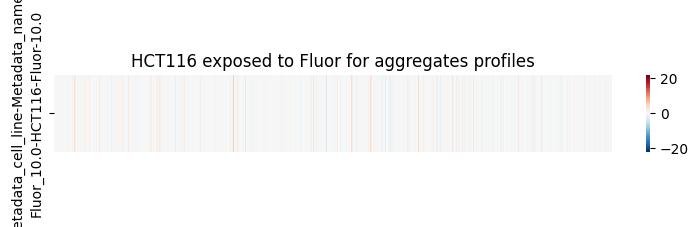

In [79]:
#Plot the morphological profile

import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(9,1))
# sns.heatmap(compound_df.set_index(metadata), cmap='RdBu_r', xticklabels=False, vmin=-7, vmax=7)
sns.heatmap(compound_df.set_index(metadata), cmap='RdBu_r', xticklabels=False, vmin=-22, vmax=22)
plt.title(title)

plt.show()

Volcano plot

In [80]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

# Identify feature columns (exclude metadata)
feature_cols = list_features(aggregate_df)

# Extract control group from full data
control_data = data.query(
    'Metadata_cell_line == @cell_line & Metadata_name == "dmso"'
)

# Extract compound group from full data
compound_data = data.query(
    'Metadata_cell_line == @cell_line & Metadata_name == @cmpd & Metadata_cmpd_conc == @conc'
)

# Compute median difference and t-test p-values
diffs = compound_data[feature_cols].median() - control_data[feature_cols].median()
pvals = [ttest_ind(compound_data[feat], control_data[feat], equal_var=False).pvalue for feat in feature_cols]

# Create result DataFrame
results_df = pd.DataFrame({
    'feature': feature_cols,
    'diff': diffs.values,
    'pval': pvals
})
results_df['neg_log10_pval'] = -np.log10(results_df['pval'])
results_df['significant'] = (results_df['pval'] < 0.05) & (np.abs(results_df['diff']) > 0.5)

# Sort significant features
significant_features = results_df[results_df['significant']].sort_values(by='pval')


In [81]:
significant_features

,feature,diff,pval,neg_log10_pval,significant
458,Granularity_2_SYTO_cells,-1.281301,1.355073e-15,14.868037,True
90,Granularity_2_HOECHST_cells,0.677033,1.453300e-08,7.837645,True
276,Correlation_Correlation_HOECHST_SYTO_cells,1.471921,3.427824e-07,6.464981,True
470,RadialDistribution_MeanFrac_PHAandWGA_2of4_cyt...,-0.853219,4.790046e-07,6.319660,True
569,Correlation_Correlation_HOECHST_MITO_nuclei,1.492435,1.217965e-05,4.914365,True
...,...,...,...,...,...
195,Neighbors_SecondClosestDistance_Adjacent_cytop...,1.590201,4.563890e-02,1.340665,True
578,AreaShape_Zernike_7_3_cells,0.558596,4.581674e-02,1.338976,True
110,Granularity_3_PHAandWGA_cytoplasm,0.707079,4.685016e-02,1.329289,True
396,RadialDistribution_RadialCV_SYTO_1of4_nuclei,1.557136,4.829874e-02,1.316064,True


In [82]:
volcano_df = results_df.sort_values(by='pval')

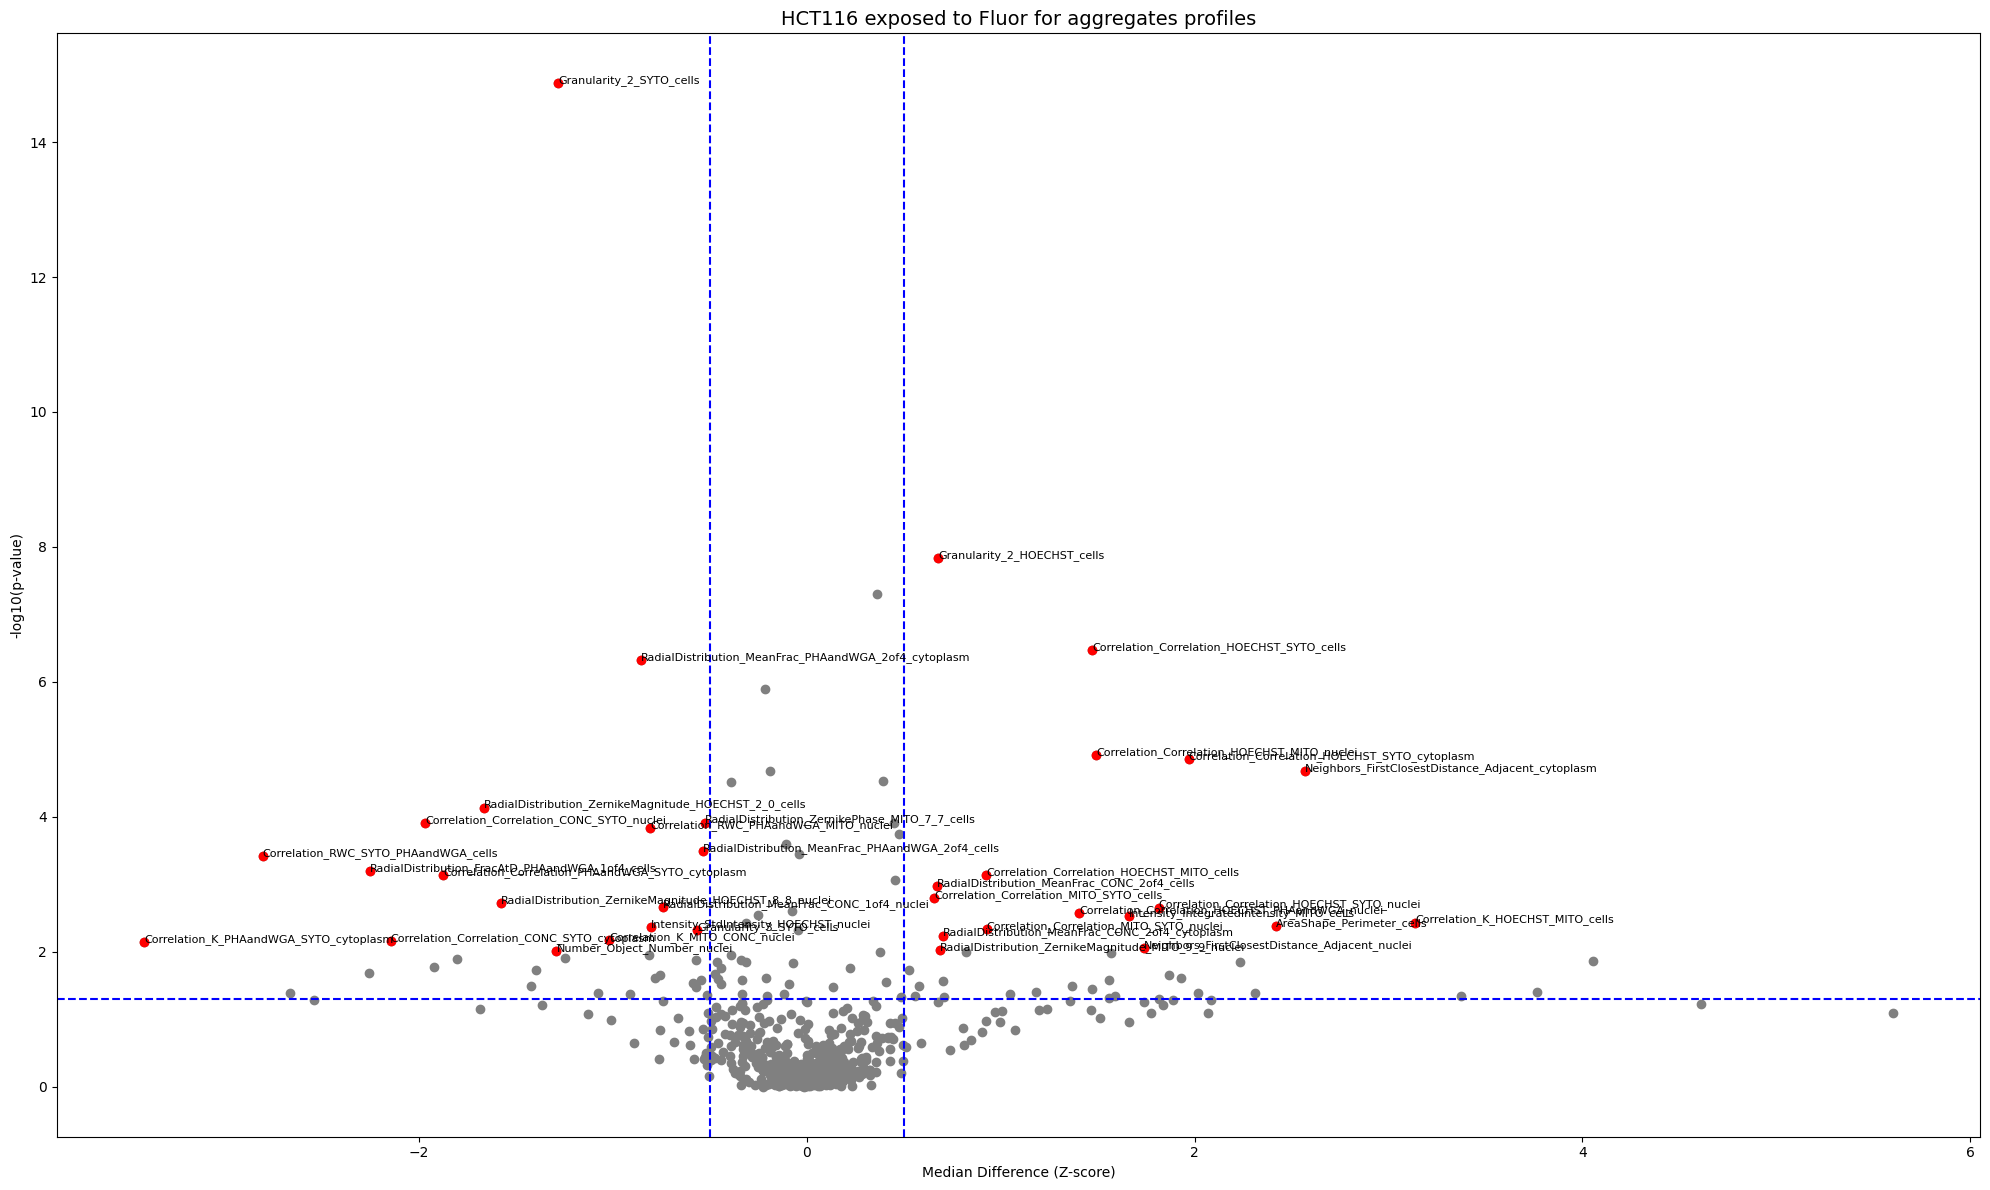

In [83]:
# Volcano plot
plt.figure(figsize=(20, 12))
plt.scatter(volcano_df['diff'], volcano_df['neg_log10_pval'], c='grey')

# Highlight significant points
sig_mask = (volcano_df['pval'] < 0.01) & (np.abs(volcano_df['diff']) > 0.5)
plt.scatter(volcano_df.loc[sig_mask, 'diff'], volcano_df.loc[sig_mask, 'neg_log10_pval'], c='red')

# Annotate
for _, row in volcano_df[sig_mask].iterrows():
    plt.text(row['diff'], row['neg_log10_pval'], row['feature'], fontsize=8)

plt.axhline(-np.log10(0.05), linestyle='--', color='blue')
plt.axvline(0.5, linestyle='--', color='blue')
plt.axvline(-0.5, linestyle='--', color='blue')
plt.xlabel('Median Difference (Z-score)')
plt.ylabel('-log10(p-value)')
plt.title(title, size=14)
plt.tight_layout()
plt.show()

